In [5]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
from re import X
import matplotlib.pyplot as plt



train_data = datasets.MNIST(
    root= 'data',
    train= True,
    transform= ToTensor(),
    download= True
)
test_data = datasets.MNIST(
    root= 'data',
    train= False,
    transform= ToTensor(),
    download= True
)




tensor([5, 0, 4,  ..., 5, 6, 8])

In [18]:
loaders = {
    'train' : DataLoader(train_data,batch_size=100,shuffle=True,num_workers=1)
   ,'test' : DataLoader(test_data,batch_size=100,shuffle=True,num_workers=1)
}
loaders

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        self.bn1 = nn.BatchNorm2d(10)
        self.bn2 = nn.BatchNorm2d(20)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.bn1(self.conv1(x)), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.bn2(self.conv2(x))), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        return F.log_softmax(self.fc2(x), dim=1)

def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
model.apply(init_weights)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
loss_fn = nn.CrossEntropyLoss()

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(loaders['train']):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 20 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(loaders["train"].dataset)} ({100. * batch_idx / len(loaders["train"]):.0f}%)]\tLoss: {loss.item():.6f}')

def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loaders['test']:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(loaders['test'])
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(loaders["test"].dataset)} '
          f'({100. * correct / len(loaders["test"].dataset):.0f}%)\n')

for epoch in range(1, 11):
     train(epoch)
     test()



Train Epoch: 1 [0/60000 (0%)]	Loss: 5.267636
Train Epoch: 1 [2000/60000 (3%)]	Loss: 2.410453
Train Epoch: 1 [4000/60000 (7%)]	Loss: 2.146905
Train Epoch: 1 [6000/60000 (10%)]	Loss: 1.877725
Train Epoch: 1 [8000/60000 (13%)]	Loss: 1.768968
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.635097
Train Epoch: 1 [12000/60000 (20%)]	Loss: 1.580552
Train Epoch: 1 [14000/60000 (23%)]	Loss: 1.151091
Train Epoch: 1 [16000/60000 (27%)]	Loss: 1.098768
Train Epoch: 1 [18000/60000 (30%)]	Loss: 0.912780
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.866934
Train Epoch: 1 [22000/60000 (37%)]	Loss: 0.922944
Train Epoch: 1 [24000/60000 (40%)]	Loss: 0.812461
Train Epoch: 1 [26000/60000 (43%)]	Loss: 0.958470
Train Epoch: 1 [28000/60000 (47%)]	Loss: 0.795921
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.655109
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.740463
Train Epoch: 1 [34000/60000 (57%)]	Loss: 0.587491
Train Epoch: 1 [36000/60000 (60%)]	Loss: 0.517166
Train Epoch: 1 [38000/60000 (63%)]	Loss: 0.622833
Train Epoch

KeyboardInterrupt: 

Prediction: 6


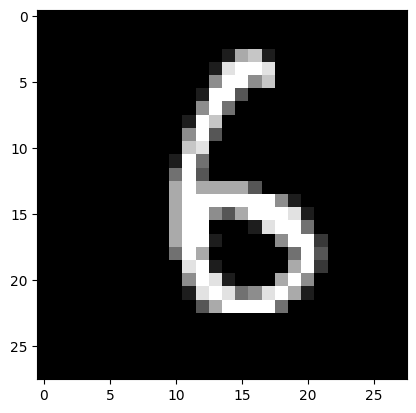

In [19]:
model.eval()
data, target = test_data[3000]
data = data.unsqueeze(0).to(device)
output = model(data)
prediction = output.argmax(dim=1, keepdim=True).item()
print(f'Prediction: {prediction}')
image = data.squeeze(0).squeeze(0).cpu().numpy()
plt.imshow(image, cmap='gray')
plt.show()